# 질문-대답 훈련 분석

*Note: 라이브러리 버전 차이로 책의 결과와 다를 수 있습니다.*

## 라이브러리 임포트

In [1]:
import importlib
import os

from keras.layers import Input, Embedding, GRU, GRUCell, Bidirectional, TimeDistributed, Dense, Lambda
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import plot_model

import numpy as np
import random

from utils.write import training_data, test_data, collapse_documents, expand_answers, _read_data, glove, START_TOKEN, END_TOKEN, look_up_token

import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/haesun/github/GDL_code/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/haesun/github/GDL_code/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/haesun/github/GDL_code/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/haesun/github/GDL_co

In [2]:
# run params
SECTION = 'write'
RUN_ID = '0001'
DATA_NAME = 'qa'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'load' #'load' #

## 데이터 적재

In [3]:
test_data_gen = test_data()
batch = next(test_data_gen)
batch = collapse_documents(batch)

## 파라미터

In [4]:
VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

GRU_UNITS = 100
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None

## 모델 생성

In [5]:
#### 훈련 모델 ####

document_tokens = Input(shape=(MAX_DOC_SIZE,), name="document_tokens")

embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIMENS, weights=[glove], mask_zero = True, name = 'embedding')
document_emb = embedding(document_tokens)

answer_outputs = Bidirectional(GRU(GRU_UNITS, return_sequences=True), name = 'answer_outputs')(document_emb)
answer_tags = Dense(2, activation = 'softmax', name = 'answer_tags')(answer_outputs)

encoder_input_mask = Input(shape=(MAX_ANSWER_SIZE, MAX_DOC_SIZE), name="encoder_input_mask")
encoder_inputs = Lambda(lambda x: K.batch_dot(x[0], x[1]), name="encoder_inputs")([encoder_input_mask, answer_outputs])
encoder_cell = GRU(2 * GRU_UNITS, name = 'encoder_cell')(encoder_inputs)

decoder_inputs = Input(shape=(MAX_Q_SIZE,), name="decoder_inputs")
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable = False
decoder_cell = GRU(2 * GRU_UNITS, return_sequences = True, name = 'decoder_cell')
decoder_states = decoder_cell(decoder_emb, initial_state = [encoder_cell])

decoder_projection = Dense(VOCAB_SIZE, name = 'decoder_projection', activation = 'softmax', use_bias = False)
decoder_outputs = decoder_projection(decoder_states)

total_model = Model([document_tokens, decoder_inputs, encoder_input_mask], [answer_tags, decoder_outputs])
plot_model(total_model, to_file='model.png',show_shapes=True)

W0923 16:27:03.079575 140498483574592 deprecation_wrapper.py:119] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 16:27:03.088849 140498483574592 deprecation_wrapper.py:119] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 16:27:03.094388 140498483574592 deprecation_wrapper.py:119] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0923 16:27:03.094835 140498483574592 deprecation_wrapper.py:119] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. P

![QA 모델](model.png)

In [6]:
#### 예측을 위한 모델 ####

decoder_inputs_dynamic = Input(shape=(1,), name="decoder_inputs_dynamic")
decoder_emb_dynamic = embedding(decoder_inputs_dynamic)
decoder_init_state_dynamic = Input(shape=(2 * GRU_UNITS,), name = 'decoder_init_state_dynamic') #the embedding of the previous word
decoder_states_dynamic = decoder_cell(decoder_emb_dynamic, initial_state = [decoder_init_state_dynamic])
decoder_outputs_dynamic = decoder_projection(decoder_states_dynamic)

answer_model = Model(document_tokens, [answer_tags])
decoder_initial_state_model = Model([document_tokens, encoder_input_mask], [encoder_cell])
question_model = Model([decoder_inputs_dynamic, decoder_init_state_dynamic], [decoder_outputs_dynamic, decoder_states_dynamic])

In [7]:
### 모델 가중치 적재 ####

model_num = 1899

total_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)
question_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)
answer_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)
decoder_initial_state_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)

## 테스트

예측한 대답의 확률


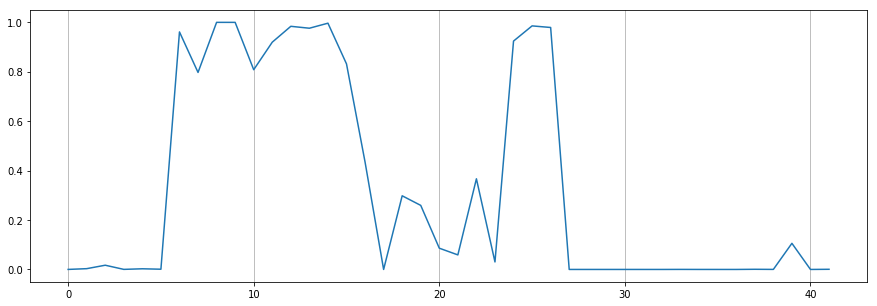

0 the 0.0
1 winning 0.0
2 goal 0.02
3 was 0.0
4 scored 0.0
5 by 0.0
6 23-year-old 0.96
7 striker 0.8
8 joe 1.0
9 bloggs 1.0
10 during 0.81
11 the 0.92
12 match 0.98
13 between 0.98
14 arsenal 1.0
15 and 0.83
16 barcelona 0.43
17 . 0.0
18 arsenal 0.3
19 recently 0.26
20 signed 0.09
21 the 0.06
22 striker 0.37
23 for 0.03
24 50 0.92
25 million 0.99
26 pounds 0.98
27 . 0.0
28 the 0.0
29 next 0.0
30 match 0.0
31 is 0.0
32 in 0.0
33 two 0.0
34 weeks 0.0
35 time, 0.0
36 on 0.0
37 july 0.0
38 31st 0.0
39 2005 0.11
40 . 0.0
41  0.0


In [8]:
# 대답 위치 예측

plt.figure(figsize=(15,5))
idx = 0

answer_preds = answer_model.predict(batch["document_tokens"])

print('예측한 대답의 확률')
ax = plt.gca()
ax.xaxis.grid(True)
plt.plot(answer_preds[idx, :, 1])
plt.show()

for i in range(len(batch['document_words'][idx])):
    print(i, batch['document_words'][idx][i], np.round(answer_preds[idx][i][1],2))

In [9]:
# 대답 위치 선정

start_answer = 37
end_answer = 39

print(batch['document_words'][idx][start_answer:(1+end_answer)])

['july', '31st', '2005']


In [10]:
answer_preds = answer_model.predict(batch["document_tokens"])

answers = [[0] * len(answer_preds[idx])]
for i in range(start_answer, end_answer + 1):
    answers[0][i] = 1

answer_batch = expand_answers(batch, answers)

next_decoder_init_state = decoder_initial_state_model.predict([answer_batch['document_tokens'][[idx]], answer_batch['answer_masks'][[idx]]])

word_tokens = [START_TOKEN]
questions = [look_up_token(START_TOKEN)]

ended = False
counter = 0

while not ended:
    
    counter += 1

    word_preds, next_decoder_init_state = question_model.predict([word_tokens, next_decoder_init_state])

    next_decoder_init_state = np.squeeze(next_decoder_init_state, axis = 1)
    word_tokens = np.argmax(word_preds, 2)[0]

    questions.append(look_up_token(word_tokens[0]))

    if word_tokens[0] == END_TOKEN or counter > 20 :
        ended = True

questions = ' '.join(questions)

In [11]:
questions

'<START> in two years ago in the international cup take place ? <END>'